In [1]:
import math
import warnings
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.api as sms
import statsmodels.stats.power as smp
from scipy.stats import binom

warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pal = [
    "#be0707",
    "#dc3248",
    "#ef5a80",
    "#f982b2",
    "#fca9dd",
    "#ffcfff",
    "#eebdfb",
    "#daacf9",
    "#c19cf8",
    "#a48ef7",
    "#7e82f7",
]

sns.set_theme(style="white", palette=pal, rc={"figure.figsize": (6, 4)})

In [2]:
from google.cloud import bigquery

project = "analytics-147612"
location = "EU"
client = bigquery.Client(project=project, location=location)


def table_reference(dataset, table):
    return f"{project}.{dataset}.{table}"


def get_table_fields(dataset, table):
    table_ref = client.get_table(table_reference(dataset, table))
    with open(f"/Users/gsokolov/Documents/{table}_fields.txt", "w") as f:
        data = {
            "table_name": table_reference(dataset, table),
            "fields": [field.name for field in table_ref.schema],
        }
        f.write(f"{data}")
    return print(data)

In [3]:
ab_users_query = """
SELECT
    properties.variant AS variant,
    SAFE_CAST(user_id AS INT64) AS user_id
FROM `analytics-147612.bloomreach_raw.campaign`
WHERE campaign_id = '65b224c42f04451aa256d565' AND action_id = 8;
"""

In [5]:
users = client.query(ab_users_query).to_dataframe()
variant_a_users = users[users["variant"] == "Variant A"]
control_users = users[users["variant"] == "Control Group"]

1. Разница по объемам по NAS100
2. по количеству сделок NAS100
3. по количеству трейдеров NAS100

In [26]:
volumes_query = """
WITH users AS (
    SELECT
        user_id,
        properties.variant AS variant
    FROM `analytics-147612.bloomreach_raw.campaign`
    WHERE campaign_id = '65b224c42f04451aa256d565' AND action_id = 8
),

traders AS (
    SELECT
        t.user_id,
        symbol_short_name,
        SUM(volume) AS vol
    FROM `analytics-147612.amplitude.events_octa_raw_trading` AS t
    -- left join users u on SAFE_CAST(u.user_id AS INT64) = t.user_id
    WHERE
        event_time_dt >= '2024-02-05'
        AND event_time_dt <= '2024-02-10'
        AND symbol_short_name = 'NAS100'
        AND event_type = 'Deal Close'
        AND t.user_id IN (SELECT SAFE_CAST(user_id AS INT64) FROM users
        )
    GROUP BY 1, 2
)


SELECT
    u.variant,
    SUM(vol) AS group_vol
FROM traders AS t
    LEFT JOIN users AS u ON SAFE_CAST(u.user_id AS INT64) = t.user_id
GROUP BY 1

"""
volumes = client.query(volumes_query).to_dataframe()

In [27]:
volumes

,variant,group_vol
0,Control Group,3.98
1,Variant A,3.20


In [ ]:
%%sql
WITH participants AS (
  SELECT
    properties.variant_name AS variant,
    properties.banner_id AS banner_id,
    internal_customer_id AS bloomreach_id,
    SAFE_CAST(user_id AS INT64) AS user_id
  FROM
    `analytics-147612.bloomreach_raw.banner`
  WHERE
    properties.banner_id = '65c38f95ede3a66b07cf898f'
)
SELECT
  p.user_id,
  p.variant,
  d.created_dt
FROM
  participants AS p 
  INNER JOIN `analytics-147612.wh_raw.deposits_enhanced` AS d ON p.user_id = d.user_id
WHERE
  p.user_id IS NOT NULL


In [40]:
converted_query = """
WITH participants AS (
  SELECT
    properties.variant_name AS variant, properties.banner_id AS banner_id,
    internal_customer_id AS bloomreach_id,
    SAFE_CAST(user_id AS INT64) AS user_id
  FROM
    `analytics-147612.bloomreach_raw.banner`
  WHERE
    properties.banner_id = '65c38f95ede3a66b07cf898f'
)
SELECT
  p.user_id,
  p.variant,
  d.created_dt
FROM
  participants AS p 
  INNER JOIN `analytics-147612.wh_raw.deposits_enhanced` AS d ON p.user_id = d.user_id
WHERE
  p.user_id IS NOT NULL

"""
converted = client.query(converted_query).to_dataframe()
converted

,user_id,variant,created_dt
0,38137110,Variant A,2024-02-08 06:08:50+00:00
1,38137110,Variant A,2024-02-08 06:08:50+00:00
2,38134360,Variant A,2024-02-08 03:22:55+00:00
3,38134360,Variant A,2024-02-08 03:22:55+00:00
4,38134360,Variant A,2024-02-09 23:47:24+00:00
5,38134360,Variant A,2024-02-09 23:47:24+00:00
6,38142024,Variant A,2024-02-08 10:35:29+00:00
7,38138994,Control Group,2024-02-08 08:24:51+00:00
8,38132999,Control Group,2024-02-08 00:21:51+00:00
9,38133497,Control Group,2024-02-10 14:00:31+00:00


In [49]:
converted_control = converted[converted["variant"] == "Control Group"].count()
converted_variant_a = converted[converted["variant"] == "Variant A"].count()

total_control, total_test = control_users.shape[0], variant_a_users.shape[0]

In [92]:
converted_control[0]

13

In [94]:
converted_control[0] / total_control * 100

0.35021551724137934

In [29]:
vols_symbols_query = """
WITH
    users AS (
        SELECT
            user_id,
            properties.variant AS variant
        FROM `analytics-147612.bloomreach_raw.campaign`
        WHERE campaign_id = '65b224c42f04451aa256d565' AND action_id = 8
    ),
    traders AS (
        SELECT
            t.user_id,
            u.variant,
            symbol_short_name,
            -- count(*) as sym_deals_cnt,
            -- sum(volume) AS sym_vol,
            volume
        FROM
            `analytics-147612.amplitude.events_octa_raw_trading` AS t
            LEFT JOIN users AS u ON SAFE_CAST(u.user_id AS INT64) = t.user_id
        WHERE
            event_time_dt >= '2024-02-05'
            AND event_time_dt <= '2024-02-10'
            -- AND symbol_short_name = 'NAS100'
            AND event_type = 'Deal Close'
            AND t.user_id IN (SELECT SAFE_CAST(user_id AS INT64) FROM users)
        -- GROUP BY 1, 2, 3
    )
SELECT DISTINCT
    user_id,
    variant,
    symbol_short_name,
    COUNT(*) AS symbol_deal_cnt,
    SUM(volume) AS sym_vol_sum
FROM traders
-- where symbol_short_name = "NAS100"
GROUP BY user_id, variant, symbol_short_name
ORDER BY user_id, variant, symbol_short_name;

"""
vols_symbols = client.query(vols_symbols_query).to_dataframe()

,user_id,variant,symbol_short_name,symbol_deal_cnt,sym_vol_sum
0,19921,Control Group,XAUUSD,13,0.13
1,20571,Variant A,XAUUSD,13,0.23
2,35873,Control Group,EURUSD,1,0.05
3,35873,Control Group,XAUUSD,13,0.65
4,55456,Variant A,XAUUSD,68,6.62
...,...,...,...,...,...
5219,37895826,Variant A,GBPAUD,3,0.05
5220,37895826,Variant A,GBPJPY,5,0.05
5221,37895826,Variant A,NAS100,1,0.01
5222,37895826,Variant A,USDCAD,9,0.09


In [95]:
res_query = """
WITH
    users AS (
        SELECT
            user_id,
            properties.variant AS variant
        FROM `analytics-147612.bloomreach_raw.campaign`
        WHERE campaign_id = '65b224c42f04451aa256d565' AND action_id = 8
    ),
    traders AS (
        SELECT
            t.user_id,
            u.variant,
            symbol_short_name,
            event_time_dt,
            -- count(*) as sym_deals_cnt,
            volume
        FROM
            `analytics-147612.amplitude.events_octa_raw_trading` AS t
            LEFT JOIN users AS u ON SAFE_CAST(u.user_id AS INT64) = t.user_id
        WHERE
            event_time_dt >= '2024-02-05'
            AND event_time_dt <= '2024-02-10'
            -- AND symbol_short_name = 'NAS100'
            AND event_type = 'Deal Close'
            AND t.user_id IN (SELECT SAFE_CAST(user_id AS INT64) FROM users)
        -- GROUP BY 1, 2, 3
    ),
    stats AS (
        SELECT
            variant,
            COUNT(DISTINCT user_id) AS traders_cnt,
            AVG(volume) AS avg_volume,
            COUNT(*) AS deal_cnt,
            SUM(
                CASE
                    WHEN symbol_short_name = 'NAS100' THEN volume
                    ELSE 0
                END
            ) AS nas100_vol,
            SUM(
                CASE
                    WHEN symbol_short_name = 'NAS100' THEN 1
                    ELSE 0
                END
            ) AS nas100_deals_cnt
        FROM traders
        GROUP BY variant
    )
SELECT *
FROM traders;
"""
res = client.query(res_query).to_dataframe()
display(res)

,variant,traders_cnt,avg_volume,deal_cnt,nas100_vol,nas100_deals_cnt
0,Variant A,1994,0.028325,75131,3.20,190
1,Control Group,2025,0.027797,77520,3.98,246


In [96]:
all_deals_query = """
WITH users AS (
    SELECT
        user_id,
        properties.variant AS variant
    FROM `analytics-147612.bloomreach_raw.campaign`
    WHERE campaign_id = '65b224c42f04451aa256d565' AND action_id = 8
),

traders AS (
    SELECT
        t.user_id,
        u.variant,
        symbol_short_name,
        event_time_dt,
        -- count(*) as sym_deals_cnt, 
        volume
    FROM `analytics-147612.amplitude.events_octa_raw_trading` AS t
    LEFT JOIN users AS u ON SAFE_CAST(u.user_id AS INT64) = t.user_id
    WHERE
        event_time_dt >= '2024-02-05'
        AND event_time_dt <= '2024-02-10'
        -- AND symbol_short_name = 'NAS100'
        AND event_type = 'Deal Close'
        AND t.user_id IN (SELECT SAFE_CAST(user_id AS INT64) FROM users
        )
-- GROUP BY 1, 2, 3
),

stats AS (
    SELECT
        variant,
        COUNT(DISTINCT user_id) AS traders_cnt,
        AVG(volume) AS avg_volume,
        COUNT(*) AS deal_cnt,
        SUM(CASE WHEN symbol_short_name = 'NAS100' THEN volume ELSE 0 END)
            AS nas100_vol,
        SUM(CASE WHEN symbol_short_name = 'NAS100' THEN 1 ELSE 0 END)
            AS nas100_deals_cnt
    FROM traders
    GROUP BY variant
)

SELECT * FROM traders
"""
all_deals = client.query(all_deals_query).to_dataframe()

In [98]:
all_deals = all_deals.drop(
    all_deals[all_deals["user_id"].isin([2353629, 37446642])].index
)
grouped_deals = (
    all_deals.groupby("variant")
    .agg({"volume": "sum", "user_id": "nunique"})
    .reset_index()
)

,user_id,variant,symbol_short_name,event_time_dt,volume
0,10564864,Control Group,XAUUSD,2024-02-08 14:30:09+00:00,0.08
1,10564864,Control Group,XAUUSD,2024-02-08 14:30:09+00:00,0.05
2,10564864,Control Group,AUDCAD,2024-02-08 13:43:57+00:00,0.01
3,10564864,Control Group,XAUUSD,2024-02-08 14:30:09+00:00,0.08
4,10564864,Control Group,XAUUSD,2024-02-08 14:30:09+00:00,0.08
...,...,...,...,...,...
152646,6432969,Variant A,XAUUSD,2024-02-08 07:46:40+00:00,0.01
152647,6432969,Variant A,XAUUSD,2024-02-08 07:46:23+00:00,0.01
152648,6432969,Variant A,XAUUSD,2024-02-08 07:30:34+00:00,0.01
152649,6432969,Variant A,XAUUSD,2024-02-08 08:30:36+00:00,0.01


In [120]:
deals_control = all_deals[all_deals["variant"] == "Control Group"]
deals_test = all_deals[all_deals["variant"] == "Variant A"]

In [104]:
grouped_deals = (
    nas100_deals.groupby("variant")
    .agg({"volume": "sum", "user_id": "nunique"})
    .reset_index()
)
grouped_deals = grouped_deals.rename(
    columns={"volume": "sum_volume", "user_id": "traders_cnt"}
)
grouped_deals

,variant,sum_volume,traders_cnt
0,Control Group,1.34,14
1,Variant A,3.20,43


In [106]:
# Filter the data for NAS100 deals
nas100_deals = all_deals[all_deals["symbol_short_name"] == "NAS100"]

# Calculate the total count of deals on NAS100 for every user
total_deals_per_user = nas100_deals.groupby("user_id").size()
total_nas100_volume = (
    nas100_deals.groupby("user_id")
    .agg({"volume": "sum"})
    .rename(columns={"volume": "total_nas100_volume"})
)
# Create a dataframe for all users with their variant
all_users_variants = all_deals[["user_id", "variant"]].drop_duplicates()

# Merge this dataframe with the total_deals_per_user, filling missing values with 0 for users with no NAS100 deals
nas100_deals_summary = pd.DataFrame(
    total_deals_per_user, columns=["NAS100_deals"]
).reset_index()
nas100_deals_summary = all_users_variants.merge(
    nas100_deals_summary, on="user_id", how="left"
).fillna(0)

# Convert NAS100_deals column to integer type to remove decimal point
nas100_deals_summary["NAS100_deals"] = nas100_deals_summary["NAS100_deals"].astype(int)

nas100_deals_summary.head()

,user_id,variant,NAS100_deals
0,10564864,Control Group,0
1,29928704,Control Group,0
2,36437760,Control Group,0
3,16677889,Control Group,0
4,7900161,Variant A,0


In [124]:
# Calculate the total volume traded on NAS100 for every user
total_volume_per_user = nas100_deals.groupby("user_id")["volume"].sum()

# Merge this information with the nas100_deals_summary table
nas100_deals_summary_with_volume = nas100_deals_summary.merge(
    pd.DataFrame(total_volume_per_user).reset_index(), on="user_id", how="left"
).fillna(0)

# Rename the volume column appropriately
nas100_deals_summary_with_volume.rename(
    columns={"volume": "NAS100_volume_traded"}, inplace=True
)

nas100_deals_summary_with_volume.head()

,user_id,variant,NAS100_deals,NAS100_volume_traded
0,10564864,Control Group,0,0.0
1,29928704,Control Group,0,0.0
2,36437760,Control Group,0,0.0
3,16677889,Control Group,0,0.0
4,7900161,Variant A,0,0.0


In [127]:
test = nas100_deals_summary_with_volume[
    nas100_deals_summary_with_volume["variant"] == "Variant A"
]
control = nas100_deals_summary_with_volume[
    (nas100_deals_summary_with_volume["variant"] == "Control Group")
]

In [149]:
test["NAS100_deals"].sum()

190

In [154]:
1.86 / 1.34

1.3880597014925373

In [155]:
0.00094 / 0.00066

1.4242424242424243

In [128]:
control

,user_id,variant,NAS100_deals,NAS100_volume_traded
0,10564864,Control Group,0,0.0
1,29928704,Control Group,0,0.0
2,36437760,Control Group,0,0.0
3,16677889,Control Group,0,0.0
9,4986116,Control Group,0,0.0
...,...,...,...,...
4006,37149813,Control Group,0,0.0
4009,25842236,Control Group,0,0.0
4011,27978845,Control Group,0,0.0
4013,31294096,Control Group,0,0.0


In [133]:
avg_nas100_control = np.mean(control["NAS100_volume_traded"])

In [136]:
avg_nas100_control

0.000662382600098863

In [132]:
avg_nas100_test = np.mean(test["NAS100_volume_traded"])

In [137]:
avg_nas100_test

0.0016048144433299899

In [139]:
from scipy import stats
from scipy.stats import mannwhitneyu

u_stat, p_val = mannwhitneyu(control["NAS100_deals"], test["NAS100_deals"])
print(u_stat, p_val)
# Interpretation
# alpha = 0.05
# if p_val < alpha:
#     print(f"p = {p_val: .3f}")
#     print("We reject null hypothesis and means are significantly different")
# else:
#     print("We fail to reject null hypothesis and means are not significantly different")

1987380.0 8.675190726463256e-05


In [135]:
stats.ttest_ind(control["NAS100_volume_traded"], test["NAS100_volume_traded"])

TtestResult(statistic=-1.5235290904203365, pvalue=0.12770514433190322, df=4015.0)

In [32]:
only_nas = vols_symbols[vols_symbols["symbol_short_name"] == "NAS100"]
control = only_nas[only_nas["variant"] == "Control Group"]
treatment = only_nas[only_nas["variant"] == "Variant A"]

In [75]:
control = control.drop(control[control["user_id"].isin([2353629, 37446642])].index)

In [85]:
control["sym_vol_sum"].sum() / control["user_id"].count()

0.09571428571428574

In [79]:
control

,user_id,variant,symbol_short_name,symbol_deal_cnt,sym_vol_sum
108,545551,Control Group,NAS100,1,0.01
232,1338510,Control Group,NAS100,3,0.06
1119,10101382,Control Group,NAS100,1,0.01
1731,14900628,Control Group,NAS100,1,0.01
1745,15015761,Control Group,NAS100,1,0.02
1995,16965745,Control Group,NAS100,3,0.03
2146,17830227,Control Group,NAS100,1,0.01
2272,18756945,Control Group,NAS100,18,0.25
3218,28702860,Control Group,NAS100,1,0.01
3302,29475946,Control Group,NAS100,33,0.77


In [83]:
treatment

,user_id,variant,symbol_short_name,symbol_deal_cnt,sym_vol_sum
59,310124,Variant A,NAS100,2,0.02
78,380170,Variant A,NAS100,7,0.07
312,2218723,Variant A,NAS100,7,0.08
396,2693567,Variant A,NAS100,9,0.20
415,2849315,Variant A,NAS100,1,0.01
523,4020659,Variant A,NAS100,12,0.52
605,4756342,Variant A,NAS100,2,0.02
1353,12385230,Variant A,NAS100,2,0.02
1399,12644612,Variant A,NAS100,4,0.06
1431,12827790,Variant A,NAS100,3,0.03


In [86]:
treatment["sym_vol_sum"].sum() / treatment["user_id"].count()

0.07441860465116279

In [88]:
control["sym_vol_sum"].median()

0.02

In [87]:
treatment["sym_vol_sum"].median()

0.02

In [72]:
(1.21 + 1.43) / control["sym_vol_sum"].sum()

0.6633165829145725

In [38]:
treatment.shape[0]

43

In [34]:
treatment["symbol_deal_cnt"].sum()

190

In [70]:
from statsmodels.stats.proportion import proportions_ztest

z_stat, p_value = proportions_ztest(
    [control["user_id"].nunique(), treatment["user_id"].nunique()],
    [total_control, total_test],
)
print(z_stat, p_value)

-3.4939672432330546 0.0004758994065004662


In [157]:
full_ab_res_query = """
DECLARE window_start DATE;
DECLARE window_end DATE;
DECLARE lookback_start DATE;
DECLARE lookback_end DATE;
SET window_start = '{window_start}';
SET window_end = date_add('{window_start}', INTERVAL 7 DAY);
SET lookback_start = date_sub('{window_start}', INTERVAL 1 MONTH);
SET lookback_end = date_sub('{window_start}', INTERVAL 1 DAY);

WITH
ab_users AS (
    SELECT
        properties.variant AS variant,
        safe_cast(user_id AS INT64) AS user_id
    FROM `analytics-147612.bloomreach_raw.campaign`
    WHERE campaign_id = '6527fb0ce60fa3775132be1e' AND action_id = 54
),

first_deal AS (
    SELECT
        abu.user_id,
        abu.variant,
        min(rt.event_time_dt) AS first_deal_date,
    FROM ab_users AS abu
    INNER JOIN
        `analytics-147612.amplitude.events_octa_raw_trading` AS rt
        ON abu.user_id = rt.user_id
    WHERE
        rt.event_type = 'Deal Close'
        AND date(rt.event_time_dt) BETWEEN '2023-10-22' AND '2023-10-27'
    GROUP BY abu.user_id, abu.variant
),

first_nas100_deal AS (
    SELECT
        rt.user_id,
        min(event_time_dt) AS first_nas100_deal_date,
        sum(volume) AS nas100_volume,
    FROM `analytics-147612.amplitude.events_octa_raw_trading` AS rt
    INNER JOIN first_deal AS fd ON rt.user_id = fd.user_id
    WHERE
        event_type = 'Deal Close'
        AND symbol_short_name = 'NAS100'
        AND date(event_time_dt) BETWEEN date(fd.first_deal_date) AND date(
            fd.first_deal_date + INTERVAL 1 DAY
        )
    GROUP BY user_id
)

SELECT
    fd.user_id,
    abu.variant,
    fd.first_deal_date,
    fnd.first_nas100_deal_date,
    fnd.nas100_volume,
    date_diff(fnd.first_nas100_deal_date, fd.first_deal_date, DAY)
        AS conversion_window,
    CASE
        WHEN fnd.first_nas100_deal_date IS NOT NULL THEN 1
        ELSE 0
    END AS converted
FROM first_deal AS fd
LEFT JOIN first_nas100_deal AS fnd ON fd.user_id = fnd.user_id
LEFT JOIN ab_users AS abu ON fd.user_id = abu.user_id;
""".format(
    window_start="2023-10-22"
)
full_ab_res = client.query(full_ab_res_query).to_dataframe()

In [320]:
# Метрики по группам
display(
    full_ab_res.groupby(["variant", "converted"])
    .agg({"user_id": "nunique"})
    .rename(columns={"user_id": "user_cnt"})
)

ab_res = full_ab_res.groupby("variant").agg(
    {"converted": "mean", "nas100_volume": ["mean", "sum"]}
)
ab_res.columns = ["conversion", "average_volume", "total_volume"]
ab_res["conversion"] = ab_res["conversion"].apply(lambda x: "{:.3%}".format(x))
display(ab_res)

user_cnt
variant       converted          
Control Group 0             43926
              1              2526
Variant A     0             43255
              1              3026

,conversion,average_volume,total_volume
variant,,,
Control Group,5.377%,0.547952,1423.58
Variant A,6.541%,0.612960,1927.76


In [87]:
# Выгрузка результатов AB-теста промо NAS100 & USD30 при условии отсутсвия сделок на NAS100 в течение месяца до начала теста

nas_funnel_query = """
DECLARE window_start DATE;
DECLARE window_end DATE;
DECLARE lookback_start DATE;
DECLARE lookback_end DATE;
SET window_start = '{window_start}';
SET window_end = date_add('{window_start}', INTERVAL 7 DAY);
SET lookback_start = date_sub('{window_start}', INTERVAL 1 MONTH);
SET lookback_end = date_sub('{window_start}', INTERVAL 1 DAY);

WITH
ab_users AS (
    SELECT
        properties.variant AS variant,
        safe_cast(user_id AS INT64) AS user_id
    FROM `analytics-147612.bloomreach_raw.campaign`
    WHERE campaign_id = '6527fb0ce60fa3775132be1e' AND action_id = 54
),

eligible_users AS (
    SELECT
        rt.user_id,
        variant
    FROM `analytics-147612.amplitude.events_octa_raw_trading` rt
    INNER JOIN ab_users ON rt.user_id = ab_users.user_id
    WHERE
        event_type = 'Deal Close'
        AND date(event_time_dt) BETWEEN lookback_start AND lookback_end
        AND rt.user_id NOT IN
        (
            SELECT user_id
            FROM `analytics-147612.amplitude.events_octa_raw_trading`
            WHERE
                event_type = 'Deal Close'
                AND symbol_short_name = 'NAS100'
                AND date(event_time_dt) BETWEEN lookback_start AND lookback_end
        )
    GROUP BY user_id, variant
),

first_deal AS (
    SELECT
        user_id,
        min(event_time_dt) AS first_deal_date
    FROM `analytics-147612.amplitude.events_octa_raw_trading`
    WHERE
        event_type = 'Deal Close'
        AND date(event_time_dt) BETWEEN window_start AND window_end
        AND user_id IN
        (
            SELECT user_id
            FROM eligible_users
        )
    GROUP BY user_id
),

first_nas100_deal AS (
    SELECT
        rt.user_id,
        min(event_time_dt) AS first_nas100_deal_date,
        sum(volume) AS nas100_volume
    FROM `analytics-147612.amplitude.events_octa_raw_trading` AS rt
    INNER JOIN first_deal AS fd ON rt.user_id = fd.user_id
    WHERE
        event_type = 'Deal Close'
        AND symbol_short_name = 'NAS100'
        AND date(event_time_dt) BETWEEN date(fd.first_deal_date) AND date(
            fd.first_deal_date + INTERVAL 7 DAY
        )
    GROUP BY user_id
)

SELECT
    fd.user_id,
    abu.variant,
    fd.first_deal_date,
    fnd.first_nas100_deal_date,
    fnd.nas100_volume,
    date_diff(fnd.first_nas100_deal_date, fd.first_deal_date, DAY)
        AS conversion_window,
    CASE
        WHEN fnd.first_nas100_deal_date IS NOT NULL THEN 1
        ELSE 0
    END AS converted
FROM first_deal AS fd
LEFT JOIN first_nas100_deal AS fnd ON fd.user_id = fnd.user_id
LEFT JOIN ab_users AS abu ON fd.user_id = abu.user_id;
"""
nas_funnel = client.query(
    nas_funnel_query.format(window_start="2023-10-22")
).to_dataframe()

In [ ]:
# Выгрузка результатов AB-теста промо NAS100 & USD30 при условии отсутсвия сделок на NAS100 в течение месяца до начала теста

nas_funnel_query = """
DECLARE window_start DATE;
DECLARE window_end DATE;
DECLARE lookback_start DATE;
DECLARE lookback_end DATE;
SET window_start = '{window_start}';
SET window_end = date_add('{window_start}', INTERVAL 7 DAY);
SET lookback_start = date_sub('{window_start}', INTERVAL 1 MONTH);
SET lookback_end = date_sub('{window_start}', INTERVAL 1 DAY);

WITH
    ab_users AS (
        SELECT
            properties.variant AS variant,
            SAFE_CAST(user_id AS INT64) AS user_id
        FROM `analytics-147612.bloomreach_raw.campaign`
        WHERE campaign_id = '6527fb0ce60fa3775132be1e' AND action_id = 54
    ),
    eligible_users AS (
        SELECT
            rt.user_id,
            variant
        FROM
            `analytics-147612.amplitude.events_octa_raw_trading` AS rt
            INNER JOIN ab_users ON rt.user_id = ab_users.user_id
        WHERE
            event_type = 'Deal Close'
            AND date(event_time_dt) BETWEEN lookback_start AND lookback_end
            AND rt.user_id NOT IN (
                SELECT user_id
                FROM `analytics-147612.amplitude.events_octa_raw_trading`
                WHERE
                    event_type = 'Deal Close'
                    AND symbol_short_name = 'NAS100'
                    AND date(
                        event_time_dt
                    ) BETWEEN lookback_start AND lookback_end
            )
        GROUP BY user_id, variant
    ),
    first_deal AS (
        SELECT
            user_id,
            min(event_time_dt) AS first_deal_date
        FROM `analytics-147612.amplitude.events_octa_raw_trading`
        WHERE
            event_type = 'Deal Close'
            AND date(event_time_dt) BETWEEN window_start AND window_end
            AND user_id IN (
                SELECT user_id
                FROM eligible_users
            )
        GROUP BY user_id
    ),
    first_nas100_deal AS (
        SELECT
            rt.user_id,
            min(event_time_dt) AS first_nas100_deal_date,
            sum(volume) AS nas100_volume
        FROM
            `analytics-147612.amplitude.events_octa_raw_trading` AS rt
            INNER JOIN first_deal AS fd ON rt.user_id = fd.user_id
        WHERE
            event_type = 'Deal Close'
            AND symbol_short_name = 'NAS100'
            AND date(event_time_dt) BETWEEN date(fd.first_deal_date) AND date(
                fd.first_deal_date + INTERVAL 7 DAY
            )
        GROUP BY user_id
    )
SELECT
    fd.user_id,
    abu.variant,
    fd.first_deal_date,
    fnd.first_nas100_deal_date,
    fnd.nas100_volume,
    date_diff(
        fnd.first_nas100_deal_date,
        fd.first_deal_date,
        DAY
    ) AS conversion_window,
    CASE
        WHEN fnd.first_nas100_deal_date IS NOT NULL THEN 1
        ELSE 0
    END AS converted
FROM
    first_deal AS fd
    LEFT JOIN first_nas100_deal AS fnd ON fd.user_id = fnd.user_id
    LEFT JOIN ab_users AS abu ON fd.user_id = abu.user_id;
"""
nas_funnel = client.query(
    nas_funnel_query.format(window_start="2023-10-22")
).to_dataframe()

In [539]:
nas_res = (
    nas_funnel.groupby("variant")
    .agg({"converted": "mean", "nas100_volume": "sum"})
    .to_dict()
)

cr_control, cr_treatment = (
    nas_res["converted"]["Control Group"],
    nas_res["converted"]["Variant A"],
)
volume_treatment, volume_control = (
    nas_res["nas100_volume"]["Variant A"],
    nas_res["nas100_volume"]["Control Group"],
)

In [714]:
# Метрики по группа для отфильтрованных пользователей

print(
    """CR for Variant A: {:.3f}, 
CR for Control Group: {:.3f},
Volume for Variant A: {:.2f},
Volume for Control Group: {:.2f}
""".format(
        cr_treatment, cr_control, volume_treatment, volume_control
    )
)

CR for Variant A: 0.026, 
CR for Control Group: 0.015,
Volume for Variant A: 246.34,
Volume for Control Group: 110.30


In [720]:
user_stats_query = """WITH 
ab_users AS (
    SELECT
        properties.variant AS variant,
        SAFE_CAST(user_id AS INT64) AS user_id
    FROM `analytics-147612.bloomreach_raw.campaign`
    WHERE campaign_id = '6527fb0ce60fa3775132be1e' AND action_id = 54
),
user_deals AS (
    SELECT
        user_id,
        symbol_short_name,
        event_time_dt,
        volume,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY event_time_dt) AS deal_rank,
        SUM(volume) OVER (PARTITION BY user_id) AS total_volume,
        COUNT(*) OVER (PARTITION BY user_id) AS total_deals,
        (
            SELECT MIN(event_time_dt)
            FROM `analytics-147612.amplitude.events_octa_raw_trading`
            WHERE
                event_type = 'Deal Close'
                AND user_id = ud.user_id
                AND symbol_short_name = 'NAS100'
                and event_time_dt >= '2023-10-30'
        ) AS first_nas100_deal_date
    FROM
        `analytics-147612.amplitude.events_octa_raw_trading` ud
    WHERE
        event_type = 'Deal Close'
        AND user_id IN (select user_id from ab_users)
        and event_time_dt >= '2023-10-30'
),
first_deals AS (
    SELECT *
    FROM user_deals
    WHERE deal_rank = 1
),
first_nas100_deals AS (
    SELECT *
    FROM user_deals
    WHERE event_time_dt = first_nas100_deal_date
)

SELECT *
FROM first_deals
UNION ALL
SELECT *
FROM first_nas100_deals;
""".format(
    # ids={", ".join(str(value) for value in ab_users["user_id"].values)}
    user_query
).format()
user_stats = client.query(user_stats_query).to_dataframe()

NameError: name 'user_query' is not defined

In [668]:
import pandas as pd
import datetime

start_date = datetime.date(2023, 1, 1)
end_date = datetime.date(2023, 12, 31)
month_starts = (
    pd.date_range(start=start_date, end=end_date, freq="MS")
    .strftime("%Y-%m-%d")
    .tolist()
)
week_starts, week_ends = [], []
for date_str in month_start:
    date = datetime.datetime.strptime(date_str, "%Y-%m-%d").date()
    next_month = date.replace(day=1) + datetime.timedelta(days=32)
    week_starts.append(next_month.replace(day=1))
    week_ends.append(week_starts[-1] + datetime.timedelta(days=6))

week_starts = [date.strftime("%Y-%m-%d") for date in week_starts]
week_ends = [date.strftime("%Y-%m-%d") for date in week_ends]

In [693]:
# CR for participants who did not trade NAS100 a month before observations
res = """
DECLARE window_start DATE;
DECLARE window_end DATE;
DECLARE lookback_start DATE;
DECLARE lookback_end DATE;
SET window_start = '{week_start}';
SET window_end = '{week_end}';
SET lookback_start = '{month_start}';
SET lookback_end = date_add('{month_start}', INTERVAL 1 MONTH);

WITH eligible_users AS (
    SELECT user_id
    FROM `analytics-147612.amplitude.events_octa_raw_trading`
    WHERE
        event_type = 'Deal Close'
        AND date(event_time_dt) BETWEEN lookback_start AND lookback_end
        AND user_id NOT IN
        (
            SELECT user_id
            FROM `analytics-147612.amplitude.events_octa_raw_trading`
            WHERE
                event_type = 'Deal Close'
                AND symbol_short_name = 'NAS100'
                AND date(event_time_dt) BETWEEN lookback_start AND lookback_end
        )
    GROUP BY user_id
),

first_deal AS (
    SELECT
        user_id,
        lookback_start as month_cohort,
        window_start as week,
        min(event_time_dt) AS first_deal_date
    FROM `analytics-147612.amplitude.events_octa_raw_trading`
    WHERE
        event_type = 'Deal Close'
        and symbol_short_name != 'NAS100'
        AND date(event_time_dt) BETWEEN window_start AND window_end
        AND user_id IN
        (
            SELECT user_id
            FROM eligible_users
        )
    GROUP BY user_id
),

first_nas100_deal AS (
    SELECT
        rt.user_id,
        min(rt.event_time_dt) AS first_nas100_deal_date,
        count(*) as cnt_nas100,
        sum(volume) AS nas100_volume
    FROM `analytics-147612.amplitude.events_octa_raw_trading` AS rt
    INNER JOIN first_deal AS fd ON rt.user_id = fd.user_id
    WHERE
        event_type = 'Deal Close'
        AND symbol_short_name = 'NAS100'
        AND date(event_time_dt) BETWEEN date(fd.first_deal_date) AND date(
            fd.first_deal_date + INTERVAL 1 WEEK
        )
    GROUP BY user_id
)

stats as (SELECT
    fd.user_id,
    fd.month_cohort,
    fd.week,
    fd.first_deal_date,
    fnd.first_nas100_deal_date,
    fnd.nas100_volume,
    fnd.cnt_nas100,
    date_diff(fnd.first_nas100_deal_date, fd.first_deal_date, DAY)
        AS conversion_window,
    CASE
        WHEN fnd.first_nas100_deal_date IS NOT NULL THEN 1
        ELSE 0
    END AS converted
FROM first_deal AS fd
LEFT JOIN first_nas100_deal AS fnd ON fd.user_id = fnd.user_id)

select count(distinct user_id) as user_cnt, month_cohort, week, sum(converted) as converted_cnt, sum(nas100_volume) as nas100_volume
"""
# result = client.query(res.format(window_start="2023-10-30")).to_dataframe()

In [694]:
cr_results = {}
for week_start, week_end, month_start, tag in zip(
    week_starts, week_ends, month_starts, list(range(1, 13))
):
    cr_results[tag] = (
        client.query(
            res.format(
                week_start=week_start, week_end=week_end, month_start=month_start
            )
        )
        .result()
        .to_dataframe()
    )

In [695]:
full_res = pd.concat(cr_results.values())

In [696]:
full_res.reset_index(drop=True, inplace=True)

# full_res = full_res.drop_duplicates(
#     subset=["user_id"]
# )
full_res = full_res.rename(columns=lambda x: x.replace("date", "ts"))
full_res["first_deal_date"] = full_res["first_deal_ts"].dt.date

display(full_res)

,user_id,month_cohort,week,first_deal_ts,first_nas100_deal_ts,nas100_volume,conversion_window,converted,first_deal_date
0,24847305,2023-01-01,2023-02-01,2023-02-01 05:22:59+00:00,NaT,NaN,<NA>,0,2023-02-01
1,16514517,2023-01-01,2023-02-01,2023-02-01 03:42:03+00:00,NaT,NaN,<NA>,0,2023-02-01
2,7496531,2023-01-01,2023-02-01,2023-02-01 07:44:54+00:00,NaT,NaN,<NA>,0,2023-02-01
3,16632713,2023-01-01,2023-02-01,2023-02-01 11:46:08+00:00,NaT,NaN,<NA>,0,2023-02-01
4,20674406,2023-01-01,2023-02-01,2023-02-01 08:50:14+00:00,NaT,NaN,<NA>,0,2023-02-01
...,...,...,...,...,...,...,...,...,...
1355236,34845886,2023-12-01,2024-01-01,2024-01-03 18:33:47+00:00,NaT,NaN,<NA>,0,2024-01-03
1355237,30348574,2023-12-01,2024-01-01,2024-01-04 00:12:40+00:00,NaT,NaN,<NA>,0,2024-01-04
1355238,14020475,2023-12-01,2024-01-01,2024-01-04 13:21:35+00:00,NaT,NaN,<NA>,0,2024-01-04
1355239,34935296,2023-12-01,2024-01-01,2024-01-04 08:49:20+00:00,NaT,NaN,<NA>,0,2024-01-04


In [703]:
full_res["month_cohort"]

0          2023-01-01
1          2023-01-01
2          2023-01-01
3          2023-01-01
4          2023-01-01
              ...    
1355236    2023-12-01
1355237    2023-12-01
1355238    2023-12-01
1355239    2023-12-01
1355240    2023-12-01
Name: month_cohort, Length: 1355241, dtype: dbdate

In [709]:
full_res[full_res["month_cohort"].astype(str) == "2023-01-01"]

,user_id,month_cohort,week,first_deal_ts,first_nas100_deal_ts,nas100_volume,conversion_window,converted,first_deal_date
0,24847305,2023-01-01,2023-02-01,2023-02-01 05:22:59+00:00,NaT,NaN,<NA>,0,2023-02-01
1,16514517,2023-01-01,2023-02-01,2023-02-01 03:42:03+00:00,NaT,NaN,<NA>,0,2023-02-01
2,7496531,2023-01-01,2023-02-01,2023-02-01 07:44:54+00:00,NaT,NaN,<NA>,0,2023-02-01
3,16632713,2023-01-01,2023-02-01,2023-02-01 11:46:08+00:00,NaT,NaN,<NA>,0,2023-02-01
4,20674406,2023-01-01,2023-02-01,2023-02-01 08:50:14+00:00,NaT,NaN,<NA>,0,2023-02-01
...,...,...,...,...,...,...,...,...,...
114390,29098085,2023-01-01,2023-02-01,2023-02-01 19:43:29+00:00,NaT,NaN,<NA>,0,2023-02-01
114391,27485965,2023-01-01,2023-02-01,2023-02-01 19:40:00+00:00,NaT,NaN,<NA>,0,2023-02-01
114392,26459760,2023-01-01,2023-02-01,2023-02-01 16:28:22+00:00,NaT,NaN,<NA>,0,2023-02-01
114393,20131497,2023-01-01,2023-02-01,2023-02-01 13:56:01+00:00,NaT,NaN,<NA>,0,2023-02-01


In [708]:
full_res[full_res["month_cohort"].astype(str) == "2023-01-01"]["user_id"].nunique()

114395

In [707]:
full_res.groupby("month_cohort").agg({"converted": "mean"})

,converted
month_cohort,
2023-01-01,0.01327
2023-02-01,0.01306
2023-03-01,0.011001
2023-04-01,0.008545
2023-05-01,0.007892
2023-06-01,0.010165
2023-07-01,0.009853
2023-08-01,0.007436
2023-09-01,0.011199


In [710]:
full_res.groupby("week").agg({"converted": "mean"})

,converted
week,
2023-02-01,0.01327
2023-03-01,0.01306
2023-04-01,0.011001
2023-05-01,0.008545
2023-06-01,0.007892
2023-07-01,0.010165
2023-08-01,0.009853
2023-09-01,0.007436
2023-10-01,0.011199


In [699]:
full_res.groupby("month_cohort").agg({"converted": "mean"}).mean()

converted    0.010303
dtype: float64

In [711]:
conversion_daily = round(
    full_res.groupby("first_deal_date")["converted"].mean() * 100, 4
)
weekly_average_conversion = round(
    full_res.groupby("first_deal_date")["converted"].mean() * 100, 4
)
weekly_average_volume = full_res.groupby("first_deal_date")["nas100_volume"].mean()
weekly_sum_of_volumes = full_res.groupby("first_deal_date")["nas100_volume"].sum()

In [713]:
pivot = full_res.pivot_table(
    index=["week"],
    values=["converted", "user_id", "nas100_volume"],
    aggfunc={"converted": "sum", "user_id": "nunique", "nas100_volume": "sum"},
).reset_index()
pivot["CR"] = (pivot["converted"] / pivot["user_id"]) * 100
pivot

,week,converted,nas100_volume,user_id,CR
0,2023-02-01,1518,446.06,114395,1.326981
1,2023-03-01,1555,247.97,119068,1.305976
2,2023-04-01,1200,168.14,109081,1.1001
3,2023-05-01,987,150.64,115512,0.854457
4,2023-06-01,962,149.23,121888,0.789249
5,2023-07-01,1197,170.19,117756,1.016509
6,2023-08-01,1181,239.67,119863,0.985292
7,2023-09-01,935,115.55,125732,0.743645
8,2023-10-01,1205,218.79,107599,1.119899
9,2023-11-01,1289,170.36,106669,1.208411


In [190]:
cum_metrics = pivot.copy()
full_res.sort_values(by=["first_deal_date"], inplace=True)
cum_metrics["Cum_CR"] = (pivot["converted"].cumsum() / pivot["user_id"].cumsum()) * 100
cum_metrics["cumulative_volume"] = pivot["nas100_volume"].cumsum()
display(cum_metrics)

,week_start,converted,nas100_volume,user_id,CR,Cum_CR,cumulative_volume
0,2023-10-30,1329,213.01,100133,1.327235,1.327235,213.01
1,2023-11-06,1326,188.06,100614,1.317908,1.32256,401.07
2,2023-11-13,1087,125.09,100850,1.077838,1.240729,526.16
3,2023-11-20,883,83.01,94282,0.936552,1.168286,609.17
4,2023-11-27,980,109.99,101853,0.962171,1.126108,719.16
5,2023-12-04,1071,133.06,94515,1.133153,1.127232,852.22
6,2023-12-11,1155,145.70,94533,1.221796,1.140249,997.92
7,2023-12-18,1063,140.37,90122,1.179512,1.144803,1138.29
8,2023-12-25,7,0.23,310,2.258065,1.145247,1138.52


In [624]:
avg_users = full_res.groupby("first_deal_date").agg({"user_id": "nunique"}).mean()

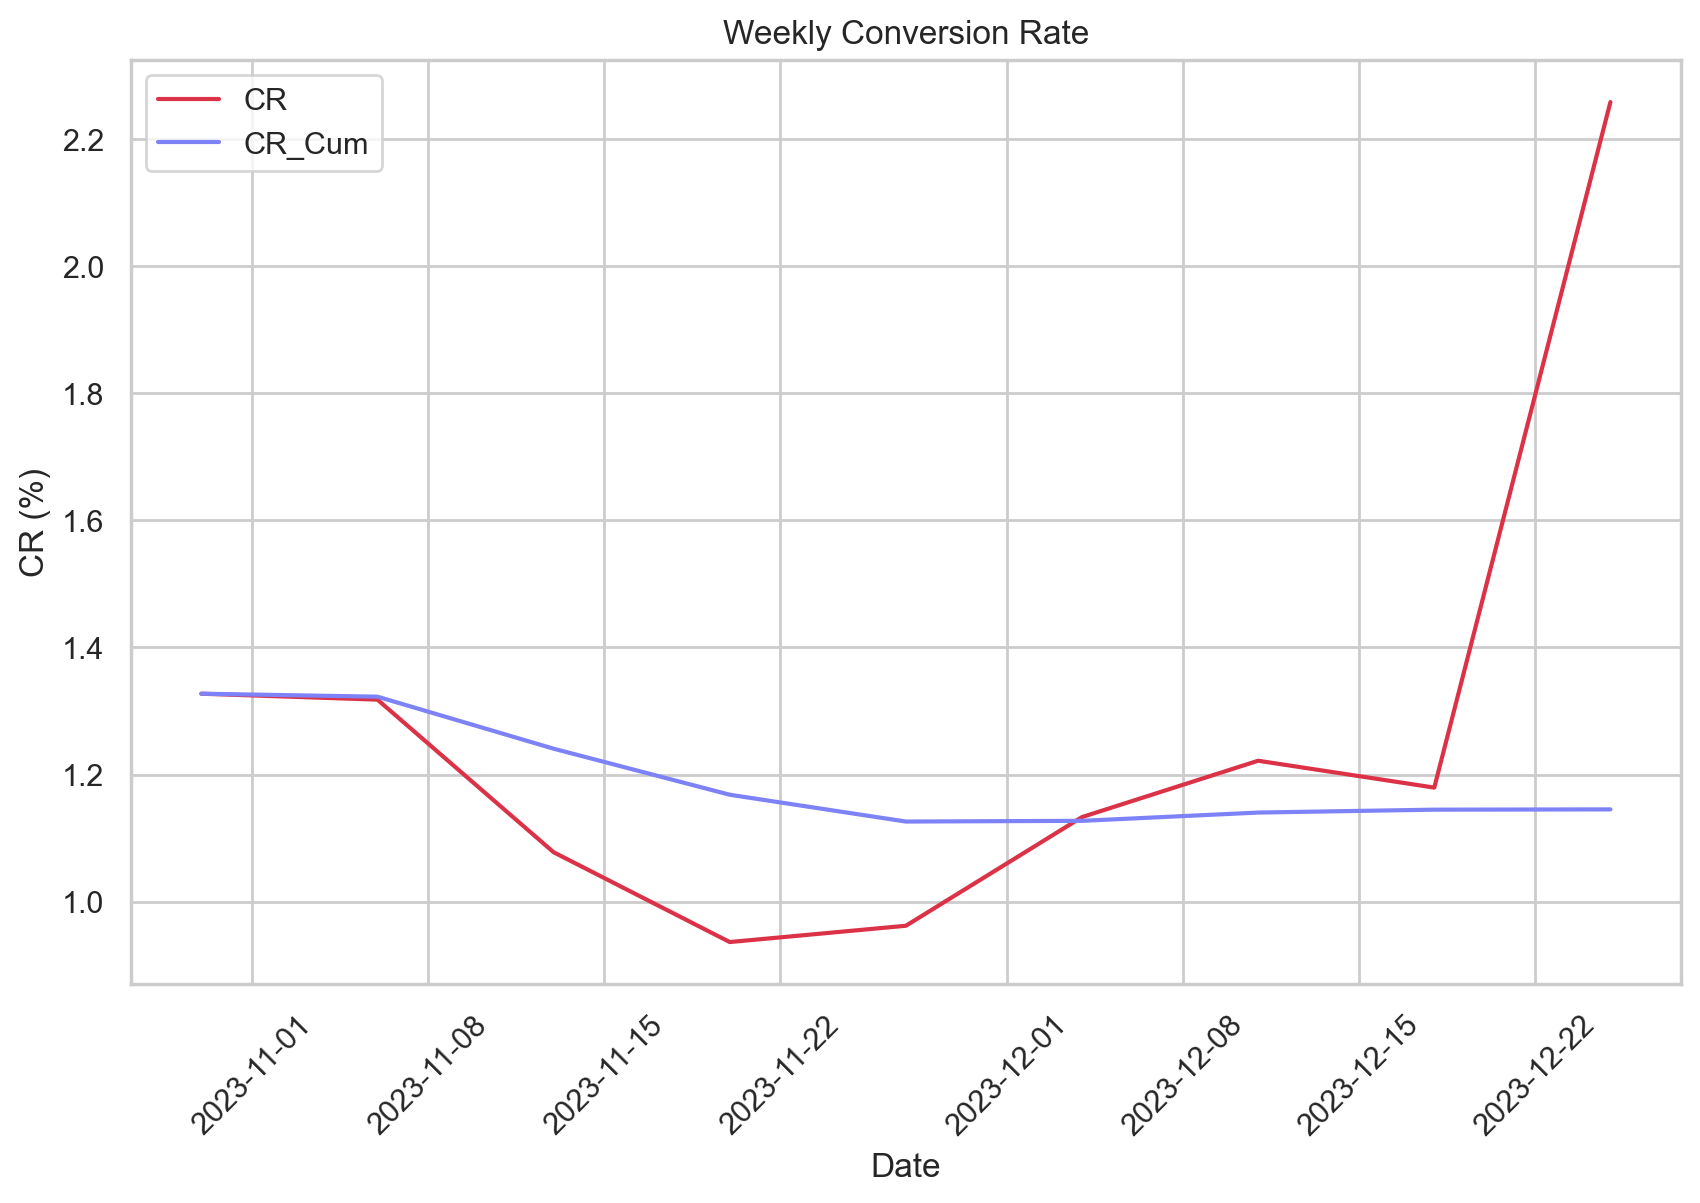

In [626]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=cum_metrics,
    x="week_start",
    y="CR",
    ax=ax1,
    label="CR",
    color=pal[1],
    legend="auto",
)
ax1.set_xlabel("Date")
ax1.set_ylabel("CR (%)")
ax1.set_title("Weekly Conversion Rate")

sns.lineplot(
    data=cum_metrics,
    x="week_start",
    y="Cum_CR",
    color=pal[10],
    legend="auto",
    label="CR_Cum",
)
ax2.set_ylabel("Cumulative CR (%)")

plt.xticks(rotation=45)

plt.show()

In [583]:
full_res["first_deal_ts"] = full_res["first_deal_ts"]
full_res["first_deal_date"] = full_res["first_deal_date"].dt.date
full_res["first_deal_ts"].groupby("user_id").nunique()

AttributeError: Can only use .dt accessor with datetimelike values

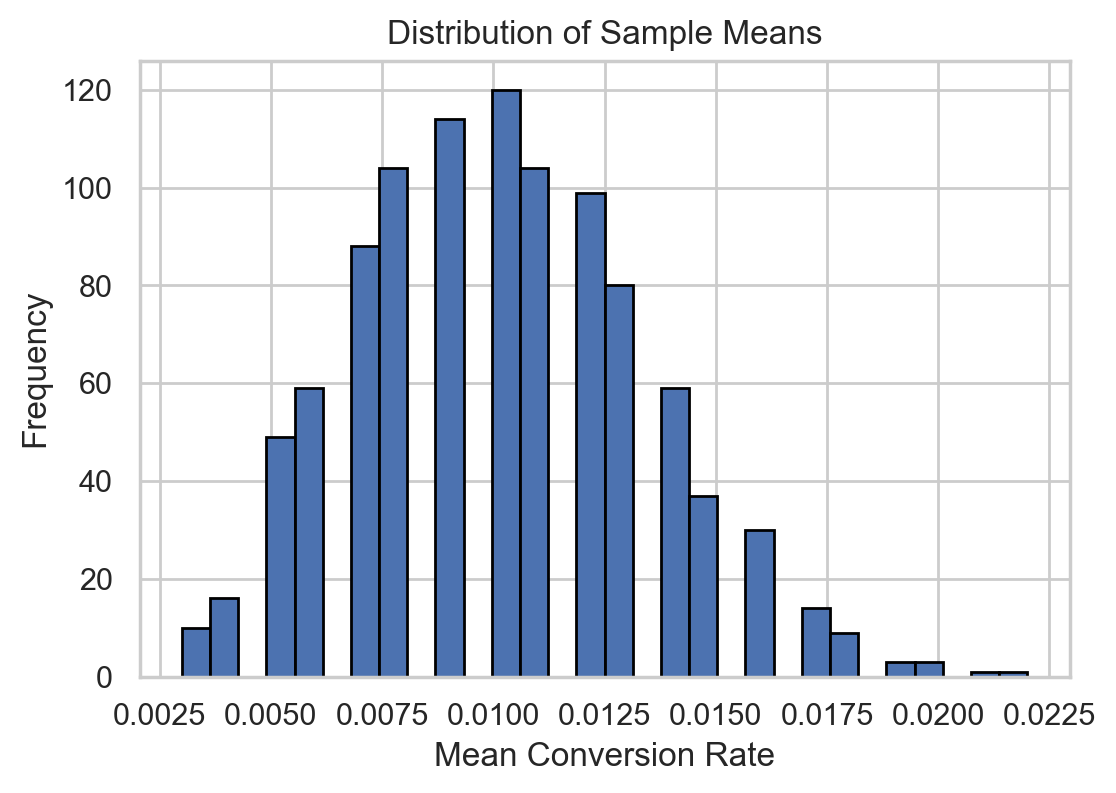

Sample does not look Gaussian (reject H0)


In [716]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro


def is_normal_distribution(sample_means):
    stat, p = shapiro(sample_means)
    alpha = 0.05
    if p > alpha:
        print("Sample looks Gaussian (fail to reject H0)")
    else:
        print("Sample does not look Gaussian (reject H0)")


def plot_distribution(sample_means):
    plt.hist(sample_means, bins=30, edgecolor="black")
    plt.title("Distribution of Sample Means")
    plt.xlabel("Mean Conversion Rate")
    plt.ylabel("Frequency")
    plt.show()


def sampling_distribution_of_means(data, n, num_samples):
    """
    data: array-like, conversion data (1 or 0)
    n: int, sample size
    num_samples: int, number of samples to draw
    """
    sample_means = [
        np.mean(np.random.choice(data, n, replace=True)) for _ in range(num_samples)
    ]
    return sample_means


sample_size = 1000  # Adjust this based on your data
num_samples = 1000  # Number of samples to draw

conversion_data = full_res["converted"].values
sample_means = sampling_distribution_of_means(conversion_data, sample_size, num_samples)

plot_distribution(sample_means)

# Testing for normality
is_normal_distribution(sample_means)

In [628]:
alpha = 0.05
power = 0.8
lift = np.round(cr_treatment / cr_control, 3)

day_traff = 2000
days = 5
n = day_traff * days

p_x = np.round(full_res["converted"].mean(), 3)
p_y = lift * p_x

effect_size = sms.proportion_effectsize(p_y, p_x)
print("Effect size:", effect_size)

size = math.ceil(
    2
    * smp.zt_ind_solve_power(
        effect_size=effect_size, alpha=alpha, power=power, alternative="two-sided"
    )
)
size_up = math.ceil(size / 1000) * 1000
print("Сколько наблюдений необходимо (обе ветки):", size)

power = smp.zt_ind_solve_power(
    effect_size=effect_size, nobs1=n / 2, alpha=alpha, alternative="two-sided"
)
print("Power:", power)

Effect size: 0.0851302092640252
Сколько наблюдений необходимо (обе ветки): 4333
Power: 0.9891776728392493


In [582]:
# Проверка чувствительности к изменению CR в контрольной группе
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05
simulations = 500
lifts = np.arange(1.4, 2.0, 0.1)
sizes = np.arange(size_up, 2 * size_up + 1, 2000)

sim_res = pd.DataFrame()

for lift, n in product(lifts, sizes):
    for _ in range(simulations):
        sampled_data = full_res.sample(n)
        sampled_data["is_control"] = np.random.binomial(1, 0.5, n)

        control_data = sampled_data[sampled_data["is_control"] == 1]
        test_data = sampled_data[sampled_data["is_control"] == 0]
        test_data["converted"] = binom.rvs(
            1, test_data["converted"].mean() * lift, size=len(test_data)
        )

        control_converted = sum(control_data["converted"])
        control_not_converted = len(control_data) - control_converted
        test_converted = sum(test_data["converted"])
        test_not_converted = len(test_data) - test_converted

        control_cr = control_converted / len(control_data)
        test_cr = test_converted / len(test_data)

        control_prop = control_cr
        test_prop = test_cr

        n_control = len(control_data)
        n_test = len(test_data)

        z_stat, p_value = proportions_ztest(
            [control_converted, test_converted], [n_control, n_test]
        )

        row = pd.DataFrame(
            {
                "lift": lift,
                "n": n,
                "pvalue": p_value,
                "z_stat": z_stat,
                "control_cr": control_cr,
                "test_cr": test_cr,
            },
            index=[len(sim_res)],
        )

        sim_res = pd.concat([sim_res, row], ignore_index=True)


def calculate_tpr(df, sim_num):
    names = {"tpr": sum(df["pvalue"] < alpha) / sim_num}
    return pd.Series(names)


res = (
    sim_res.groupby(["lift", "n"])
    .apply(calculate_tpr, sim_num=simulations)
    .reset_index()
    .sort_values(by=["tpr"], ascending=False)
)
display(res)

,lift,n,pvalue,z_stat,control_cr,test_cr
0,1.4,6000,8.197389e-03,-2.643830,0.010982,0.019284
1,1.4,6000,1.207482e-01,-1.551641,0.011282,0.015935
2,1.4,6000,1.966274e-02,-2.332722,0.009218,0.015956
3,1.4,6000,2.907621e-01,-1.056451,0.010396,0.013347
4,1.4,6000,1.188634e-01,-1.559562,0.009843,0.014228
...,...,...,...,...,...,...
34995,2.0,12000,1.626925e-09,-6.031254,0.010263,0.024669
34996,2.0,12000,6.473244e-09,-5.804049,0.008571,0.021488
34997,2.0,12000,2.273798e-07,-5.175436,0.011034,0.023279
34998,2.0,12000,1.480618e-09,-6.046461,0.010624,0.025268


,lift,n,tpr
69,2.0,12000,0.982
68,2.0,11333,0.978
66,2.0,10000,0.962
58,1.9,11333,0.962
65,2.0,9333,0.958
...,...,...,...
10,1.5,6000,0.448
1,1.4,6666,0.432
3,1.4,8000,0.420
0,1.4,6000,0.406
